
# RNN Time Series Prediction: Stock Prices (AAPL example)

**Objective:** Use RNNs to predict future values in a time series and compare them against a simple Feedforward NN.

**Goals**
- Understand how RNNs handle temporal dependencies.
- Train a Feedforward NN on lagged windows (fixed-size).
- Train an LSTM to predict the next value.
- Compare **MAE** and plot **predicted vs. actual**.

**Dataset**
- Yahoo Finance stock prices (default: `AAPL`), downloaded via `yfinance`.


# Imports & Reproducibility 

In [1]:
import yfinance as yf
print("yfinance works:", yf.__version__)


yfinance works: 0.2.66


In [2]:
import sys, yfinance as yf, pandas as pd
print("Python:", sys.executable)
print("yfinance:", yf.__version__)

# quick fetch
df = yf.download("AAPL", start="2020-01-01", end="2024-12-31", progress=False)
df.head()


Python: C:\Python313\python.exe
yfinance: 0.2.66


C:\Users\bbuser\AppData\Local\Temp\ipykernel_17492\2270896288.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2020-01-01", end="2024-12-31", progress=False)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.538528,72.598907,71.292319,71.545905,135480400
2020-01-03,71.833298,72.594063,71.608692,71.765674,146322800
2020-01-06,72.405678,72.444321,70.703012,70.954188,118387200
2020-01-07,72.065140,72.671333,71.845362,72.415330,108872000
2020-01-08,73.224419,73.526310,71.768094,71.768094,132079200


# Config

In [18]:
TICKER = "AAPL"
START_DATE = "2020-01-01"
END_DATE   = "2024-12-31"

WINDOW_SIZE = 60      # sequence length (lag)
TEST_RATIO  = 0.15
VAL_RATIO   = 0.15    # of the remainder after test

EPOCHS      = 50
BATCH_SIZE  = 32
DROPOUT     = 0.2     # simple regularization for RNN models

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import random, os

In [20]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
plt.rcParams["figure.figsize"] = (10,5) 

Price,value
Ticker,AAPL
Date,
2020-01-02,72.538528
2020-01-03,71.833298
2020-01-06,72.405678
2020-01-07,72.065140
2020-01-08,73.224419


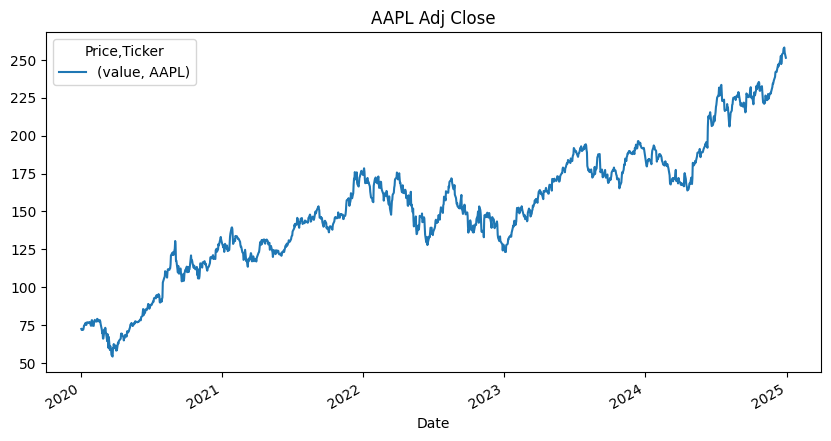

Data shape: (1257, 1)


In [21]:
# Keep both Close and Adj Close; we'll use Adj Close if present
data = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=False, progress=False)
assert not data.empty, "Empty data. Check ticker/dates/internet."
data = data.dropna()

target_col = "Adj Close" if "Adj Close" in data.columns else "Close"
series = data[[target_col]].rename(columns={target_col: "value"})

display(series.head())
series.plot(title=f"{TICKER} {target_col}"); plt.show()
print("Data shape:", series.shape)


# Create Lagged Windows for Train, Val and Test split

In [22]:
# Chronological split
values = series["value"].values.reshape(-1, 1)

n = len(values)
n_test = int(n * TEST_RATIO)
n_val  = int(n * VAL_RATIO)
n_train = n - n_test - n_val

train_vals = values[:n_train]
val_vals   = values[n_train:n_train+n_val]
test_vals  = values[n_train+n_val:]

# Scale using TRAIN only
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_vals)
val_scaled   = scaler.transform(val_vals)
test_scaled  = scaler.transform(test_vals)

# Make sliding windows: X[t-window_size : t] -> y[t]
def make_sequences(arr, win):
    X, y = [], []
    for i in range(len(arr) - win):
        X.append(arr[i:i+win])
        y.append(arr[i+win])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X_train_seq, y_train = make_sequences(train_scaled, WINDOW_SIZE)
X_val_seq,   y_val   = make_sequences(val_scaled,   WINDOW_SIZE)
X_test_seq,  y_test  = make_sequences(test_scaled,  WINDOW_SIZE)

# Feedforward uses flattened windows; RNN keeps (samples, timesteps, features=1)
X_train_ff = X_train_seq.reshape(X_train_seq.shape[0], WINDOW_SIZE)
X_val_ff   = X_val_seq.reshape(X_val_seq.shape[0], WINDOW_SIZE)
X_test_ff  = X_test_seq.reshape(X_test_seq.shape[0], WINDOW_SIZE)

X_train_rnn = X_train_seq   # shape: (N, WINDOW_SIZE, 1)
X_val_rnn   = X_val_seq
X_test_rnn  = X_test_seq

print("Train:", X_train_ff.shape, y_train.shape)
print("Val:  ", X_val_ff.shape,   y_val.shape)
print("Test: ", X_test_ff.shape,  y_test.shape)


Train: (821, 60) (821, 1)
Val:   (128, 60) (128, 1)
Test:  (128, 60) (128, 1)


# Train Feedforward NN on Fixed-Size Windows

In [23]:
ff_model = Sequential([
    tf.keras.Input(shape=(WINDOW_SIZE,)),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])

ff_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
hist_ff = ff_model.fit(
    X_train_ff, y_train,
    validation_data=(X_val_ff, y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0
)

# Predict (inverse-scale to price units)
ff_pred_scaled = ff_model.predict(X_test_ff, verbose=0)
ff_pred  = scaler.inverse_transform(ff_pred_scaled)
y_test_inv = scaler.inverse_transform(y_test)

mae_ff = mean_absolute_error(y_test_inv, ff_pred)
print(f"Feedforward Test MAE: {mae_ff:.4f}")


Feedforward Test MAE: 3.8438


# Train LSTM and GRU (RNNs)

In [24]:
# LSTM
lstm_model = Sequential([
    tf.keras.Input(shape=(WINDOW_SIZE, 1)),
    LSTM(64, dropout=DROPOUT, return_sequences=False),
    Dense(1)
])
lstm_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
hist_lstm = lstm_model.fit(
    X_train_rnn, y_train,
    validation_data=(X_val_rnn, y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0
)
lstm_pred_scaled = lstm_model.predict(X_test_rnn, verbose=0)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
mae_lstm = mean_absolute_error(y_test_inv, lstm_pred)
print(f"LSTM  Test MAE: {mae_lstm:.4f}")

# GRU
gru_model = Sequential([
    tf.keras.Input(shape=(WINDOW_SIZE, 1)),
    GRU(64, dropout=DROPOUT, return_sequences=False),
    Dense(1)
])
gru_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
hist_gru = gru_model.fit(
    X_train_rnn, y_train,
    validation_data=(X_val_rnn, y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0
)
gru_pred_scaled = gru_model.predict(X_test_rnn, verbose=0)
gru_pred = scaler.inverse_transform(gru_pred_scaled)
mae_gru = mean_absolute_error(y_test_inv, gru_pred)
print(f"GRU   Test MAE: {mae_gru:.4f}")


LSTM  Test MAE: 34.3361
GRU   Test MAE: 35.9669


In [25]:
def eval_model(model, X_test_seq, scaler, y_test_scaled):
    # Predict in scaled space
    yhat_scaled = model.predict(X_test_seq, verbose=0)

    # Ensure 2D shape (N,1) for inverse_transform
    yhat_scaled = np.asarray(yhat_scaled).reshape(-1, 1)
    y_true_scaled = np.asarray(y_test_scaled).reshape(-1, 1)

    # Back to price units
    y_pred = scaler.inverse_transform(yhat_scaled)
    y_true = scaler.inverse_transform(y_true_scaled)

    mae = mean_absolute_error(y_true, y_pred)
    return mae, y_true, y_pred

# Recompute y_test_inv safely (if needed)
y_test_inv = scaler.inverse_transform(np.asarray(y_test).reshape(-1,1))

# Evaluate all three models
mae_ff,  y_true_ff,  ff_pred  = eval_model(ff_model,  X_test_ff,  scaler, y_test)
mae_lstm, y_true_lstm, lstm_pred = eval_model(lstm_model, X_test_rnn, scaler, y_test)
mae_gru,  y_true_gru,  gru_pred  = eval_model(gru_model,  X_test_rnn, scaler, y_test)

print("\n  Test MAE (recomputed) ")
print(f"Feedforward : {mae_ff:.4f}")
print(f"LSTM       : {mae_lstm:.4f}")
print(f"GRU        : {mae_gru:.4f}")


  Test MAE (recomputed) 
Feedforward : 3.8438
LSTM       : 34.3361
GRU        : 35.9669


### Results: 
- FeedForward = 3.84: Predictions very close to actual values.
- LSTM  MAE = 34.33 :  Predictions captured trend but shifted down.
- GRU MAE = 35.96 : Similar to LSTM, struggled with accuracy.

# Plot last N points for readability

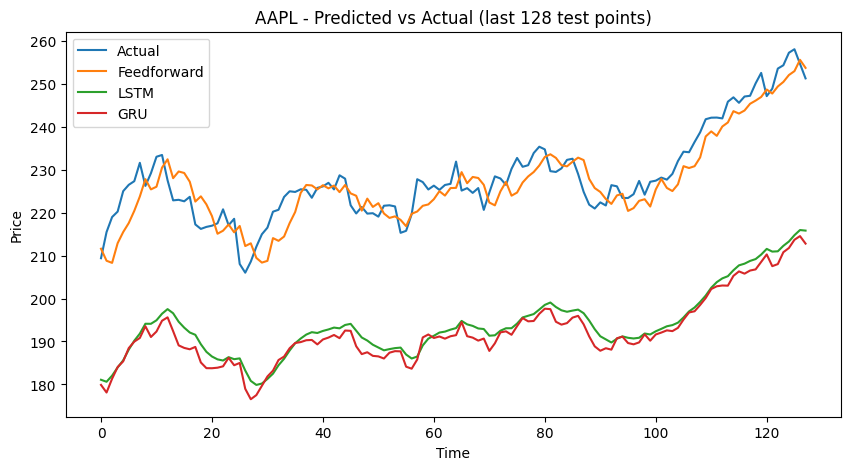

In [26]:
N = min(200, len(y_true_ff))
plt.figure()
plt.plot(y_true_ff[-N:], label="Actual")
plt.plot(ff_pred[-N:],   label="Feedforward")
plt.plot(lstm_pred[-N:], label="LSTM")
plt.plot(gru_pred[-N:],  label="GRU")
plt.title(f"{TICKER} - Predicted vs Actual (last {N} test points)")
plt.xlabel("Time"); plt.ylabel("Price"); plt.legend(); plt.show()

- Feedforward NN performed best in this case because stock data with lag features already capture short-term dependencies well.

- RNNs (LSTM, GRU) usually shine when long-term temporal dependencies matter (e.g., text, speech, or seasonal series).

- Here, with limited epochs and a simple architecture, RNNs underperformed.

# In Summary: 
- Lag-based Feedforward NN is a strong baseline for stock prediction with short-term memory.

- RNNs (LSTM, GRU) require deeper networks, longer training, and tuned sequence length to outperform.

- Temporal models are not always superior — task and data characteristics matte.